In [187]:
from transformers import BertConfig
from gnn import GNNTrainer
from dataset_preprocess import MovieLensLoader, PCA_PATH,  PROMPT_KGE_DIMENSION, EMBEDDING_KGE_DIMENSION
from llm import PromptBertClassifier, VanillaBertClassifier, AddingEmbeddingsBertClassifierBase, mean_over_ranges, VANILLA_HIDDEN_STATES_PATH, PROMPT_HIDDEN_STATES_PATH, EMBEDDING_HIDDEN_STATES_PATH, VANILLA_TOKENS_PATH, PROMPT_TOKENS_PATH, EMBEDDING_TOKENS_PATH
import joblib

from pathlib import Path
from typing import Optional, List, Tuple
import itertools
import random as rd

import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import DataLoader
import networkx as nx
from sklearn.decomposition import PCA
import pandas as pd
from scipy.spatial import ConvexHull

In [2]:
VANILLA_PCA_PATH_TEMPLATE = f"{PCA_PATH}/vanilla_{{}}_{{}}.pkl" # vanilla_{label}_{layer}.pkl
PROMPT_PCA_PATH_TEMPLATE = f"{PCA_PATH}/prompt_{PROMPT_KGE_DIMENSION}_{{}}_{{}}.pkl" # prompt_{prompt_kge_dimension}_{label}_{layer}.pkl
EMBEDDING_PCA_PATH_TEMPLATE = f"{PCA_PATH}/embedding_{EMBEDDING_KGE_DIMENSION}_{{}}_{{}}.pkl"
#We expect the templates to be of form ..{}...{}.., so the layer and token can be formatted into the name.

In [3]:
def load_hidden_states(path_to_hidden_states_npy: str | Path, path_to_df: str|Path)  -> pd.DataFrame:
    hidden_states = np.load(path_to_hidden_states_npy)
    df = pd.read_csv(path_to_df)
    df["hidden_states"] = list(hidden_states)
    return df

def init_pcas(df: pd.DataFrame, token_labels: List[str], pca_target_base_path_template: Optional[str] = None, split: Optional[str] = None) -> List[List[PCA]]:    
    if split:
        df = df[df["split"] == split]
    hidden_states = np.transpose(np.stack(df["hidden_states"].values), (1,0,2,3)) # type: ignore
    pcas = []
    for layer_num, layer in enumerate(hidden_states):
        pcas_on_layer = []
        pcas.append(pcas_on_layer)
        for idx, label in enumerate(token_labels):
            pca = PCA(n_components=2)  # Adjust number of components as needed
            pcas_on_layer.append(pca)
            position_hidden_states = layer[:,idx]
            pca.fit_transform(position_hidden_states)
            if pca_target_base_path_template:
                pca_target_path = pca_target_base_path_template.format(label, layer_num)
                joblib.dump(pca, pca_target_path)
    return pcas


In [4]:
path_to_vanilla_hidden_states = VANILLA_HIDDEN_STATES_PATH # replace with the respective path
path_to_vanilla_df = VANILLA_TOKENS_PATH # path to pandas dataframe with same size as vanilla hidden states
vanilla_hidden_states_df = load_hidden_states(path_to_vanilla_hidden_states, path_to_df=path_to_vanilla_df)
vanilla_hidden_states_shape = np.stack(vanilla_hidden_states_df["hidden_states"].values).shape # type: ignore
print(vanilla_hidden_states_shape) #  shape: (dataset length, layer, position, embedding size)
print(vanilla_hidden_states_df)

(272259, 3, 7, 128)
        user_id                                     title  \
0             0                 grumpier old men ( 1995 )   
1             0                             heat ( 1995 )   
2             0         seven ( a. k. a. se7en ) ( 1995 )   
3             0              usual suspects, the ( 1995 )   
4             0                    bottle rocket ( 1996 )   
...         ...                                       ...   
272254      216                 brokedown palace ( 1999 )   
272255      335                    sudden impact ( 1983 )   
272256       62                          elysium ( 2013 )   
272257      492  city hunter ( sing si lip yan ) ( 1993 )   
272258      564     adventures of pinocchio, the ( 1996 )   

                                                genres  labels  split  \
0                               ['comedy ', 'romance']       1  train   
1                    ['action ', 'crime ', 'thriller']       1  train   
2                           

In [8]:
prompt_hidden_states_df = load_hidden_states(PROMPT_HIDDEN_STATES_PATH, PROMPT_TOKENS_PATH)
prompt_hidden_states_shape = np.stack(prompt_hidden_states_df["hidden_states"].values).shape # type: ignore
print(vanilla_hidden_states_shape)
embedding_hidden_states_df = load_hidden_states(EMBEDDING_HIDDEN_STATES_PATH, EMBEDDING_TOKENS_PATH)

(272259, 3, 7, 128)


In [13]:
vanilla_pcas = init_pcas(vanilla_hidden_states_df, ["cls", "user", "sep1", "title", "sep2", "genres", "sep3"], VANILLA_PCA_PATH_TEMPLATE, split = "train")
embedding_token_labels = ["cls", "user", "sep1", "title", "sep2", "genres", "sep3", "user embedding", "sep4", "movie embedding", "sep5"]
prompt_pcas = init_pcas(prompt_hidden_states_df, embedding_token_labels, PROMPT_PCA_PATH_TEMPLATE, split = "train")
embedding_pcas = init_pcas(embedding_hidden_states_df, embedding_token_labels, EMBEDDING_PCA_PATH_TEMPLATE, split = "train")

In [288]:
def nearest_neighbor(point, points):
    distances = np.linalg.norm(points - point, axis=1)
    return np.argmin(distances)

def filter_by_singular_user(vanilla_df:pd.DataFrame, min_size = 25) ->pd.DataFrame:
    vanilla_count = vanilla_df['user_id'].value_counts().rename('vanilla_count')
    vanilla_count = vanilla_count[vanilla_count["vanilla_count"] >= min_size]
    if not len(vanilla_count) > 0:
        raise Exception("There are not enough user_ids matching over all models.")
    singular_user = rd.choice(vanilla_count["user_id"].unique())
    return vanilla_df[vanilla_df["user_id"] == singular_user]

def filter_by_singular_title(vanilla_df:pd.DataFrame, min_size = 25) ->pd.DataFrame:
    vanilla_count = vanilla_df['title'].value_counts().rename('vanilla_count')
    vanilla_count = vanilla_count[vanilla_count["vanilla_count"] >= min_size]
    if not len(vanilla_count) > 0:
        raise Exception("There are not enough titles matching over all models.")
    singular_user = rd.choice(vanilla_count["title"].unique())
    return vanilla_df[vanilla_df["title"] == singular_user]

def get_list_index_from_list(input_list: List, index_list: List[int]) -> List:
    result_list = []
    for idx, input_elem in enumerate(input_list):
        if idx in index_list:
            result_list.append(input_elem)
    return result_list

class HiddenStatesPlotter():

    def __init__(self, vanilla_df: pd.DataFrame, prompt_df: pd.DataFrame, embedding_df: pd.DataFrame, vanilla_pcas: List[List[PCA]], prompt_pcas: List[List[PCA]], embedding_pcas: List[List[PCA]]) -> None:
        self.vanilla_df = vanilla_df
        self.prompt_df = prompt_df
        self.embedding_df = embedding_df
        self.vanilla_pcas = vanilla_pcas
        self.prompt_pcas = prompt_pcas
        self.embedding_pcas = embedding_pcas

    def __forward_hidden_states_to_pcas(self, hidden_states: np.ndarray, pcas: List[PCA]) -> np.ndarray:
        assert len(hidden_states) == len(pcas)
        low_dim_reps = []
        for hidden_states_, pca in zip(hidden_states, pcas):
            low_dim_reps.append(pca.transform(hidden_states_))
        result = np.stack(low_dim_reps)
        return result
    
    def __preconditions_split_and_fig_size(self, samples: int, fig_size: Tuple[int, int], fig_dpi: int, split:Optional[str] = None)-> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        assert samples >= 1
        assert fig_size[0] >= 1
        assert fig_size[1] >= 1
        assert fig_dpi >= 1
        plt.rcParams['figure.figsize'] = fig_size
        plt.rcParams['figure.dpi'] = fig_dpi # 200 e.g. is really fine, but slower
        vanilla_df = self.vanilla_df
        prompt_df = self.prompt_df
        embedding_df = self.embedding_df
        if split:
            vanilla_df = vanilla_df[vanilla_df["split"] == split]
            prompt_df = prompt_df[prompt_df["split"] == split]
            embedding_df = embedding_df[embedding_df["split"] == split]
        return vanilla_df, prompt_df, embedding_df
    
    def __sample_over_all(self, samples: int, vanilla_df: pd.DataFrame, prompt_df: pd.DataFrame, embedding_df: pd.DataFrame)->Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        vanilla_df = vanilla_df.sample(samples)
        prompt_df = prompt_df.loc[vanilla_df.index].reset_index(drop=True)
        embedding_df = embedding_df.loc[vanilla_df.index].reset_index(drop=True)
        vanilla_df = vanilla_df.reset_index(drop=True)
        return vanilla_df, prompt_df, embedding_df
    
    
    
    def produce_low_dim_reps_over_layer(self, layer: int, token_index: List[int], vanilla_df: pd.DataFrame, prompt_df: pd.DataFrame, embedding_df: pd.DataFrame) -> np.ndarray:
        assert layer < len(self.vanilla_pcas)
        assert max(token_index) < len(self.vanilla_pcas[0])
        vanilla_pcas = get_list_index_from_list(self.vanilla_pcas[layer], token_index)
        prompt_pcas = get_list_index_from_list(self.prompt_pcas[layer], token_index)
        embedding_pcas = get_list_index_from_list(self.embedding_pcas[layer], token_index)
        vanilla_hidden_states = np.stack(vanilla_df["hidden_states"].tolist())[:, layer, token_index].transpose(1,0,2) # shape (token positions, dataset size, embedding size)
        prompt_hidden_states = np.stack(prompt_df["hidden_states"].tolist())[:, layer, token_index].transpose(1,0,2)
        embedding_hidden_states = np.stack(embedding_df["hidden_states"].tolist())[:, layer, token_index].transpose(1,0,2)
        low_dim_reps_vanilla = self.__forward_hidden_states_to_pcas(vanilla_hidden_states, vanilla_pcas)
        low_dim_reps_prompt = self.__forward_hidden_states_to_pcas(prompt_hidden_states, prompt_pcas)
        low_dim_reps_embedding = self.__forward_hidden_states_to_pcas(embedding_hidden_states, embedding_pcas)
        return np.stack([low_dim_reps_vanilla, low_dim_reps_prompt, low_dim_reps_embedding])
    
    def __title_figure_save(self, title: str, fig_size: Tuple[int, int], fig_dpi: int, scatter_legends: List[PathCollection], token_labels: List[str], save_path: Optional[str|Path])-> None:
        plt.legend(scatter_legends,
            token_labels,
            scatterpoints=1,
            loc='upper right',
            ncol=3,
            fontsize=8,)
        plt.title(title)
        plt.figure(figsize=fig_size, dpi=fig_dpi)
        if save_path:
            plt.savefig(save_path)
        plt.show()

    def __scatter_plot_over_low_dim_reps(self, low_dim_reps: np.ndarray, markers: List[List[str]], colors: List[List])-> List[PathCollection]:
        '''
        This method expects shapes in form of: [model, positions]
        '''
        assert len(low_dim_reps) == len(markers)
        assert len(markers) == len(colors)
        assert len(low_dim_reps[0])== len(markers[0])
        assert len(markers[0]) == len(colors[0])
        scatter_legends = []
        for low_dim_reps_on_model, markers_on_model, colors_on_model in zip(low_dim_reps, markers, colors):
            for low_dim_reps_on_position, markers_on_positon, colors_on_position in zip(low_dim_reps_on_model, markers_on_model, colors_on_model):
                scatter_legends.append(plt.scatter(low_dim_reps_on_position[:, 0], low_dim_reps_on_position[:, 1], marker=markers_on_positon, color = colors_on_position))
        return scatter_legends

    def plot_cls_embeddings(self, samples = 1, fig_size: Tuple[int, int] = (8,8), fig_dpi: int = 200, split: Optional[str] = None, save_path: Optional[str|Path] = None):
        vanilla_df, prompt_df, embedding_df = self.__preconditions_split_and_fig_size(samples, fig_size, fig_dpi, split)
        vanilla_df, prompt_df, embedding_df = self.__sample_over_all(samples, vanilla_df, prompt_df, embedding_df)

        low_dim_reps = self.produce_low_dim_reps_over_layer(-1,[0], vanilla_df, prompt_df, embedding_df)
        colors = cm.rainbow(np.linspace(0, 1, 3))# type: ignore
        scatter_legends = self.__scatter_plot_over_low_dim_reps(low_dim_reps, markers = [["o"], ["o"], ["o"]], colors = [[colors[0]], [colors[1]], [colors[2]]])
        self.__title_figure_save("CLS Tokens Embeddings in last Layer", fig_size, fig_dpi, scatter_legends, ["vanilla cls", "prompt cls", "embedding cls"], save_path)

    def plot_cls_true_vs_non_true(self, samples = 1, fig_size: Tuple[int, int] = (8,8), fig_dpi: int = 200, split: Optional[str] = None, save_path: Optional[str|Path] = None):
        vanilla_df, prompt_df, embedding_df = self.__preconditions_split_and_fig_size(samples,fig_size, fig_dpi, split)
        existing_vanilla_edges_df = vanilla_df[vanilla_df["labels"] == 1]
        non_existing_vanilla_edges_df = vanilla_df[vanilla_df["labels"] == 0]
        existing_vanilla_edges_df, existing_prompt_edges_df, existing_embedding_edges_df = self.__sample_over_all(samples, existing_vanilla_edges_df, prompt_df, embedding_df)
        non_existing_vanilla_edges_df, non_existing_prompt_edges_df, non_existing_embedding_edges_df = self.__sample_over_all(samples, non_existing_vanilla_edges_df, prompt_df, embedding_df)
        existing_low_dim_reps = self.produce_low_dim_reps_over_layer(-1,[0],existing_vanilla_edges_df, existing_prompt_edges_df, existing_embedding_edges_df)
        non_existing_low_dim_reps = self.produce_low_dim_reps_over_layer(-1,[0],non_existing_vanilla_edges_df, non_existing_prompt_edges_df, non_existing_embedding_edges_df)
        colors = cm.rainbow(np.linspace(0, 1, 2))# type: ignore
        scatter_legends = []
        scatter_legends = self.__scatter_plot_over_low_dim_reps(existing_low_dim_reps, markers = [["o"], ["X"], ["v"]], colors = [[colors[0]], [colors[0]], [colors[0]]])
        scatter_legends.extend(self.__scatter_plot_over_low_dim_reps(non_existing_low_dim_reps, markers = [["o"], ["X"], ["v"]], colors = [[colors[1]], [colors[1]], [colors[1]]]))
        self.__title_figure_save("CLS Token Embeddings in last Layer: Existing vs Non-Existing", fig_size, fig_dpi, scatter_legends, ["vanilla existing", "prompt existing", "embedding existing", "vanilla non-existing", "prompt non-existing", "embedding non-existing"], save_path)

    def plot_user_movie_embeddings_in_second_layer_true_vs_non_true(self, samples = 1, fig_size: Tuple[int, int] = (8,8), fig_dpi: int = 200, split: Optional[str] = None, save_paths: Optional[List[str|Path]] = None):
        if save_paths:
            assert len(save_paths) == 3
        else:
            save_path = None
        vanilla_df, prompt_df, embedding_df = self.__preconditions_split_and_fig_size(samples,fig_size, fig_dpi, split)
        existing_vanilla_edges_df = vanilla_df[vanilla_df["labels"] == 1]
        non_existing_vanilla_edges_df = vanilla_df[vanilla_df["labels"] == 0]
        existing_vanilla_edges_df, existing_prompt_edges_df, existing_embedding_edges_df = self.__sample_over_all(samples, existing_vanilla_edges_df, prompt_df, embedding_df)
        non_existing_vanilla_edges_df, non_existing_prompt_edges_df, non_existing_embedding_edges_df = self.__sample_over_all(samples, non_existing_vanilla_edges_df, prompt_df, embedding_df)
        low_dim_reps_existing = self.produce_low_dim_reps_over_layer(1, [2,4,6], existing_vanilla_edges_df, existing_prompt_edges_df, existing_embedding_edges_df)
        low_dim_reps_non_existing = self.produce_low_dim_reps_over_layer(1, [2,4,6], non_existing_vanilla_edges_df, non_existing_prompt_edges_df, non_existing_embedding_edges_df)
        low_dim_reps = np.concatenate([low_dim_reps_existing, low_dim_reps_non_existing])
        colors = cm.rainbow(np.linspace(0, 1, 2)) # type: ignore
        print(low_dim_reps.shape, low_dim_reps_non_existing.shape, low_dim_reps_non_existing.shape)
        scatter_legends = self.__scatter_plot_over_low_dim_reps(low_dim_reps[[0,3]], markers = [["o", "X", "v"], ["o", "X", "v"]], colors = [[colors[0],colors[0], colors[0]], [colors[1],colors[1], colors[1]]])
        token_labels = ["existing user", "existing title", "existing genres", "non-existing user", "non-existing title", "non-existing genres"]
        if save_paths:
            save_path = save_paths[0]
        self.__title_figure_save("Vanilla User, Title, Genres Token Embeddings in Second Layer existing vs non exsting", fig_size, fig_dpi, scatter_legends, token_labels, save_path)
        scatter_legends = self.__scatter_plot_over_low_dim_reps(low_dim_reps[[1,4]], markers = [["o", "X", "v"], ["o", "X", "v"]], colors = [[colors[0],colors[0], colors[0]], [colors[1],colors[1], colors[1]]])
        if save_paths:
            save_path = save_paths[1]
        self.__title_figure_save("Prompt User, Title, Genres Token Embeddings in Second Layer existing vs non exsting", fig_size, fig_dpi, scatter_legends, token_labels, save_path)
        scatter_legends = self.__scatter_plot_over_low_dim_reps(low_dim_reps[[2,5]], markers = [["o", "X", "v"], ["o", "X", "v"]], colors = [[colors[0],colors[0], colors[0]], [colors[1],colors[1], colors[1]]])
        if save_paths:
            save_path = save_paths[2]
        self.__title_figure_save("Embedding User, Title, Genres Token Embeddings in Second Layer existing vs non exsting", fig_size, fig_dpi, scatter_legends, token_labels, save_path)

In [289]:
hidden_state_plotter = HiddenStatesPlotter(vanilla_hidden_states_df, prompt_hidden_states_df, embedding_hidden_states_df, vanilla_pcas, prompt_pcas, embedding_pcas)

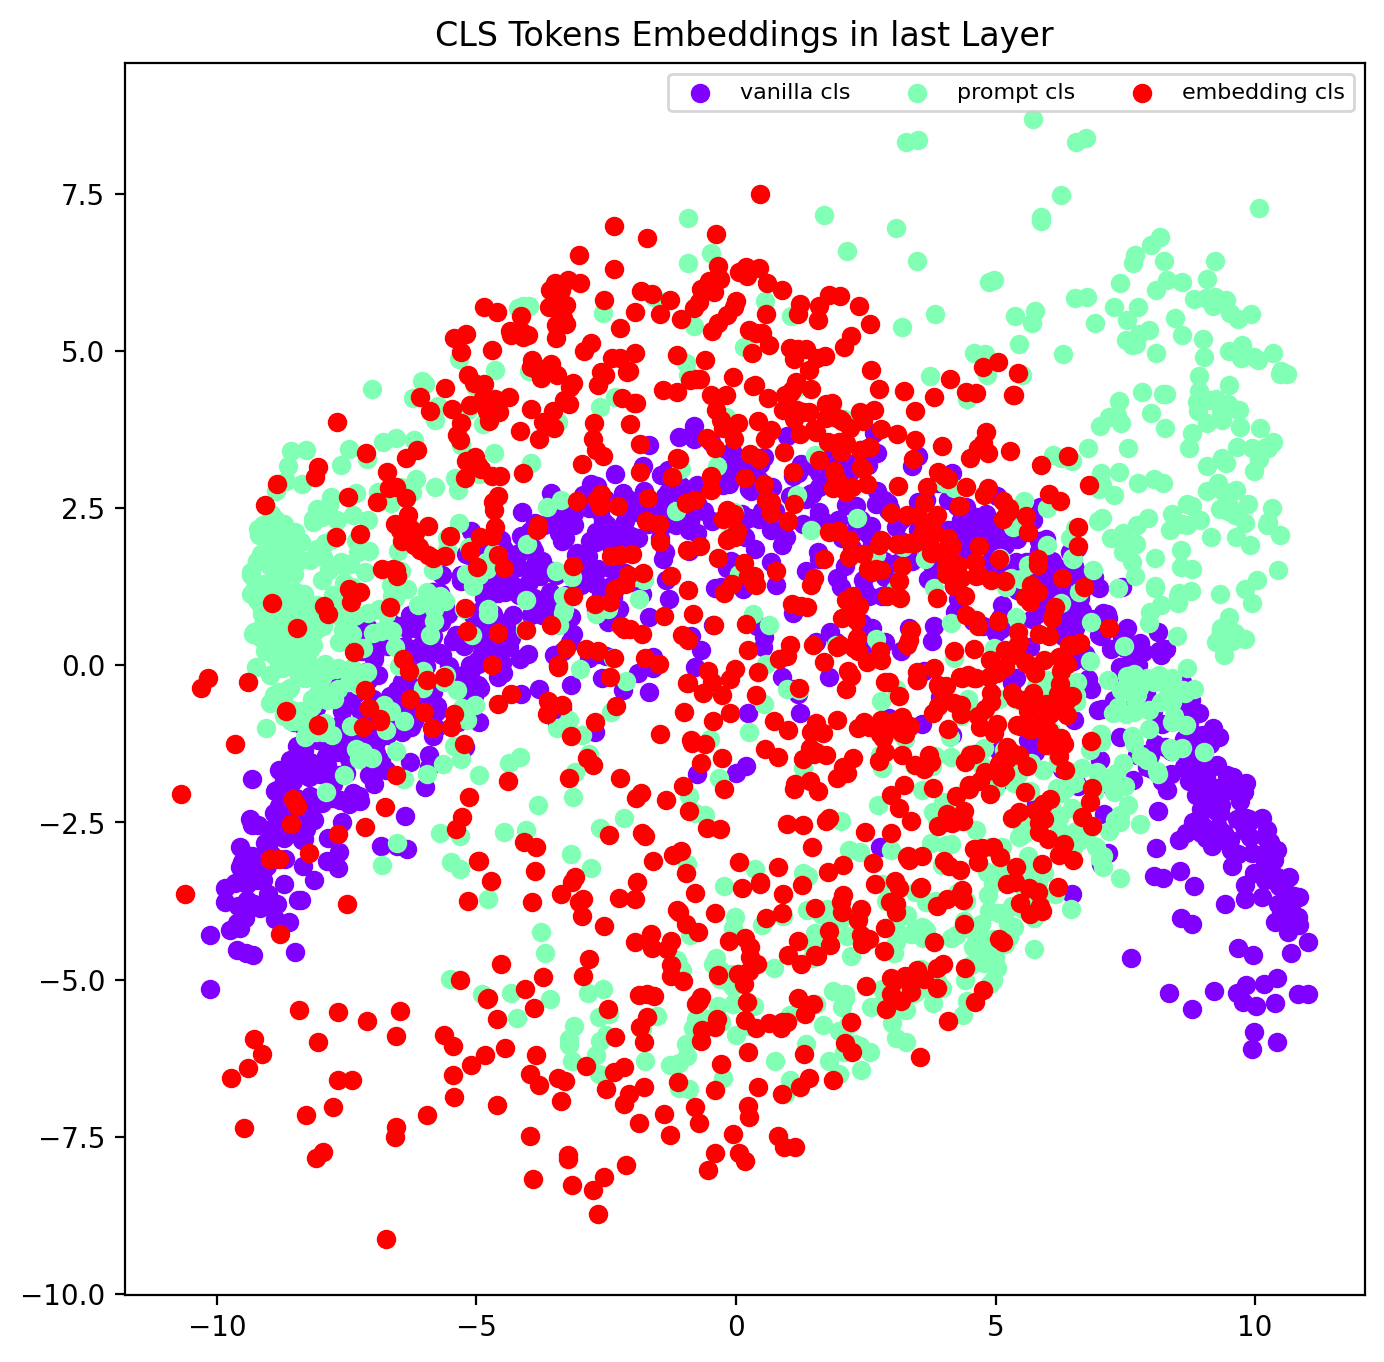

<Figure size 1600x1600 with 0 Axes>

In [290]:
hidden_state_plotter.plot_cls_embeddings(samples = 1000, split = "val")

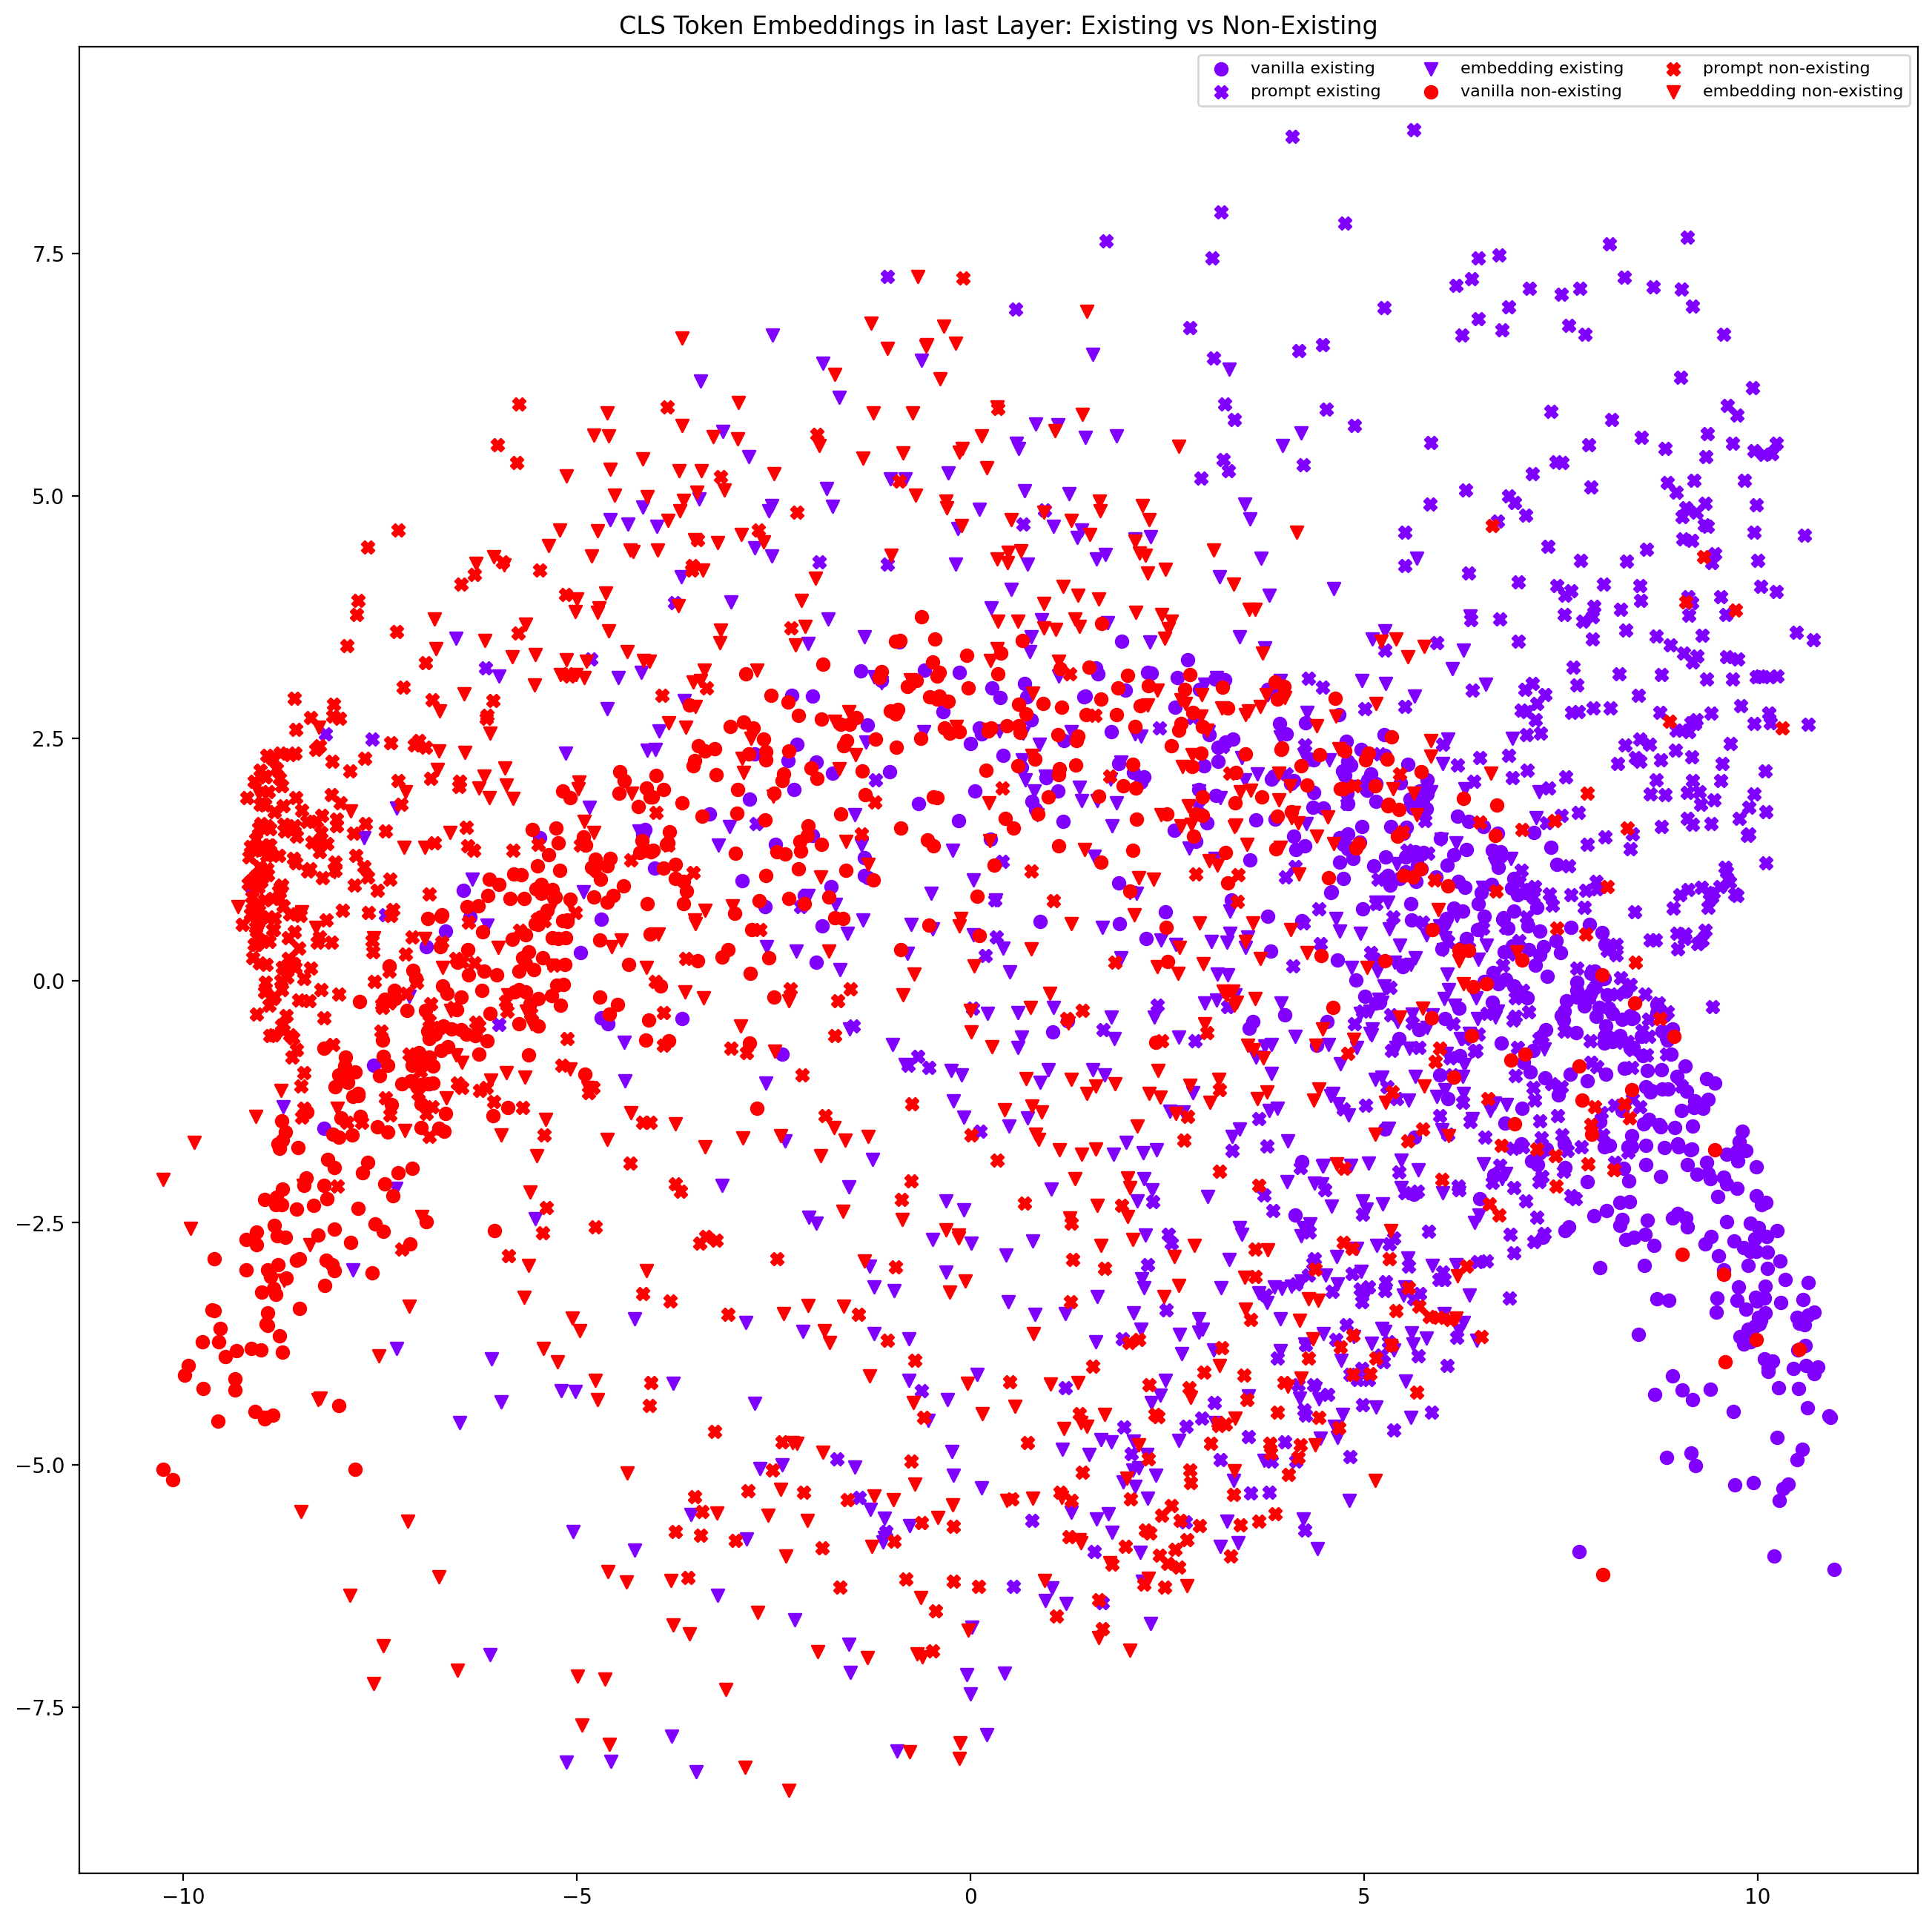

<Figure size 3200x3200 with 0 Axes>

In [291]:
hidden_state_plotter.plot_cls_true_vs_non_true(samples = 500, split = "val", fig_size=(16,16))

(6, 3, 200, 2) (3, 3, 200, 2) (3, 3, 200, 2)


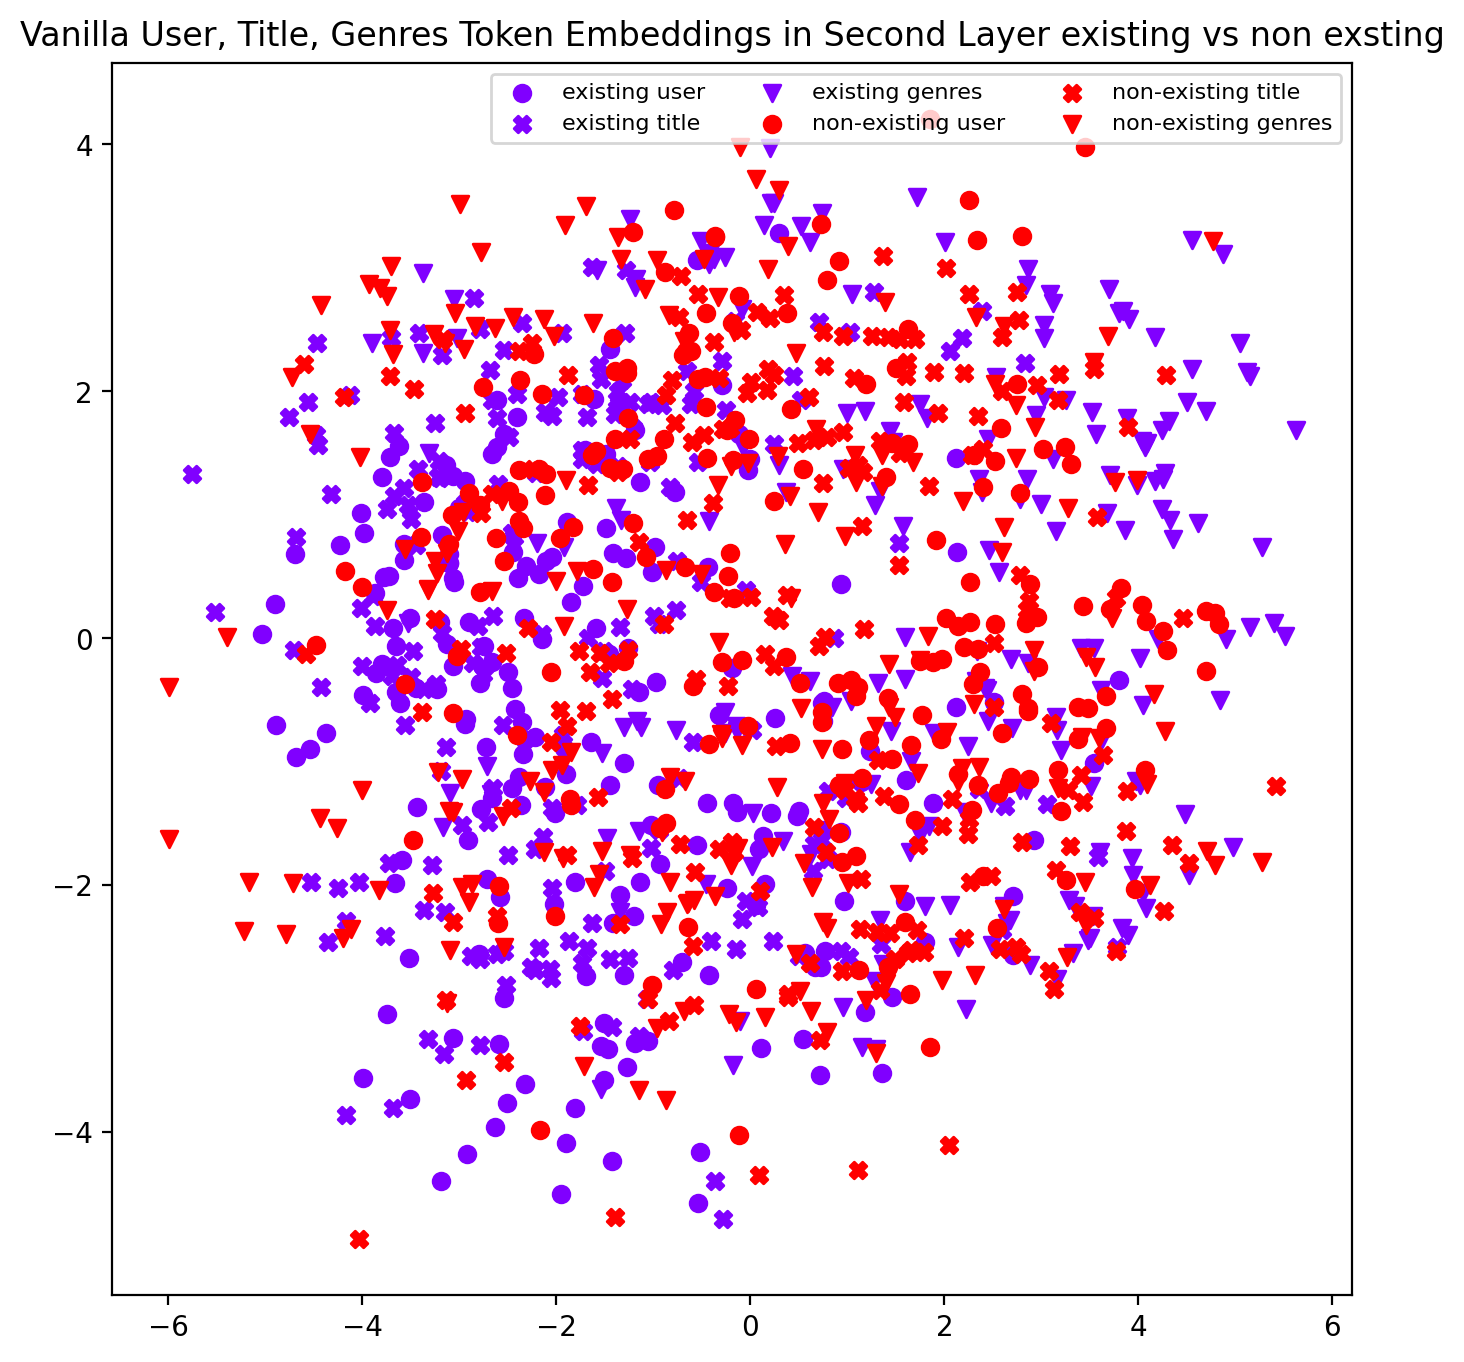

<Figure size 1600x1600 with 0 Axes>

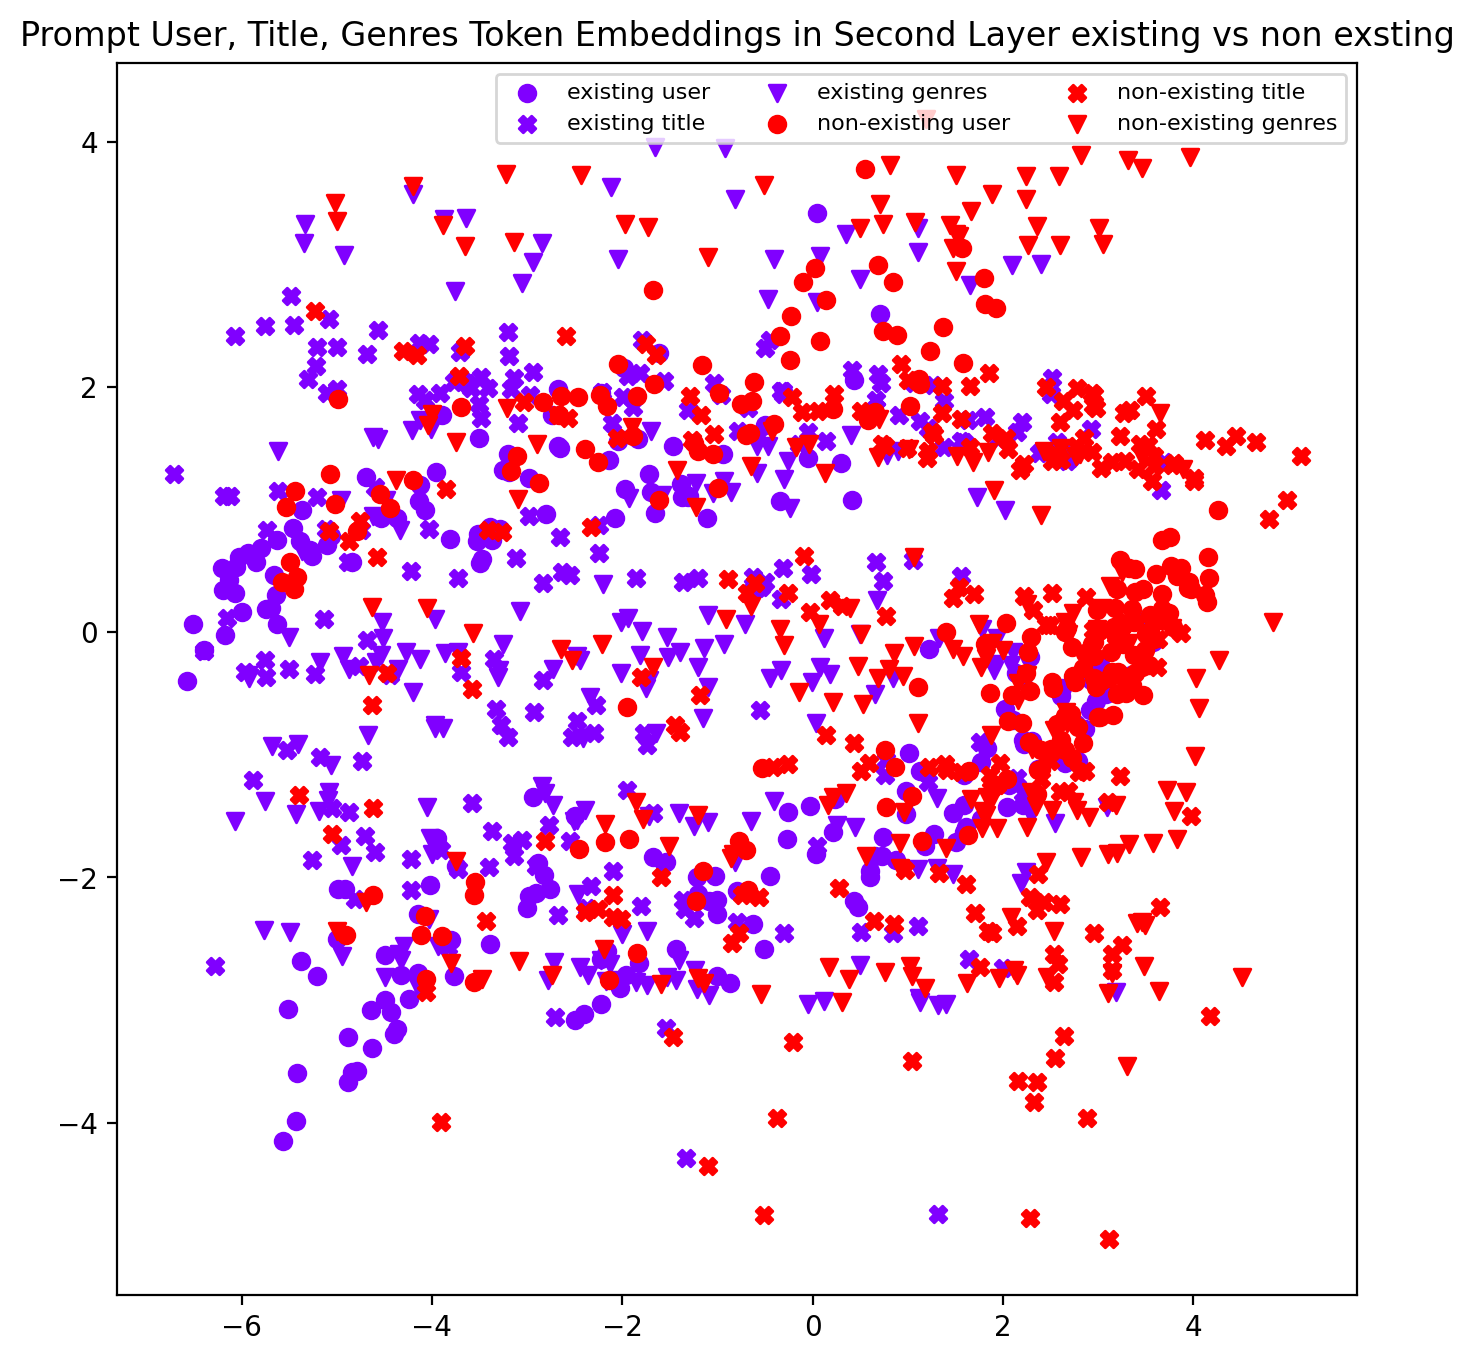

<Figure size 1600x1600 with 0 Axes>

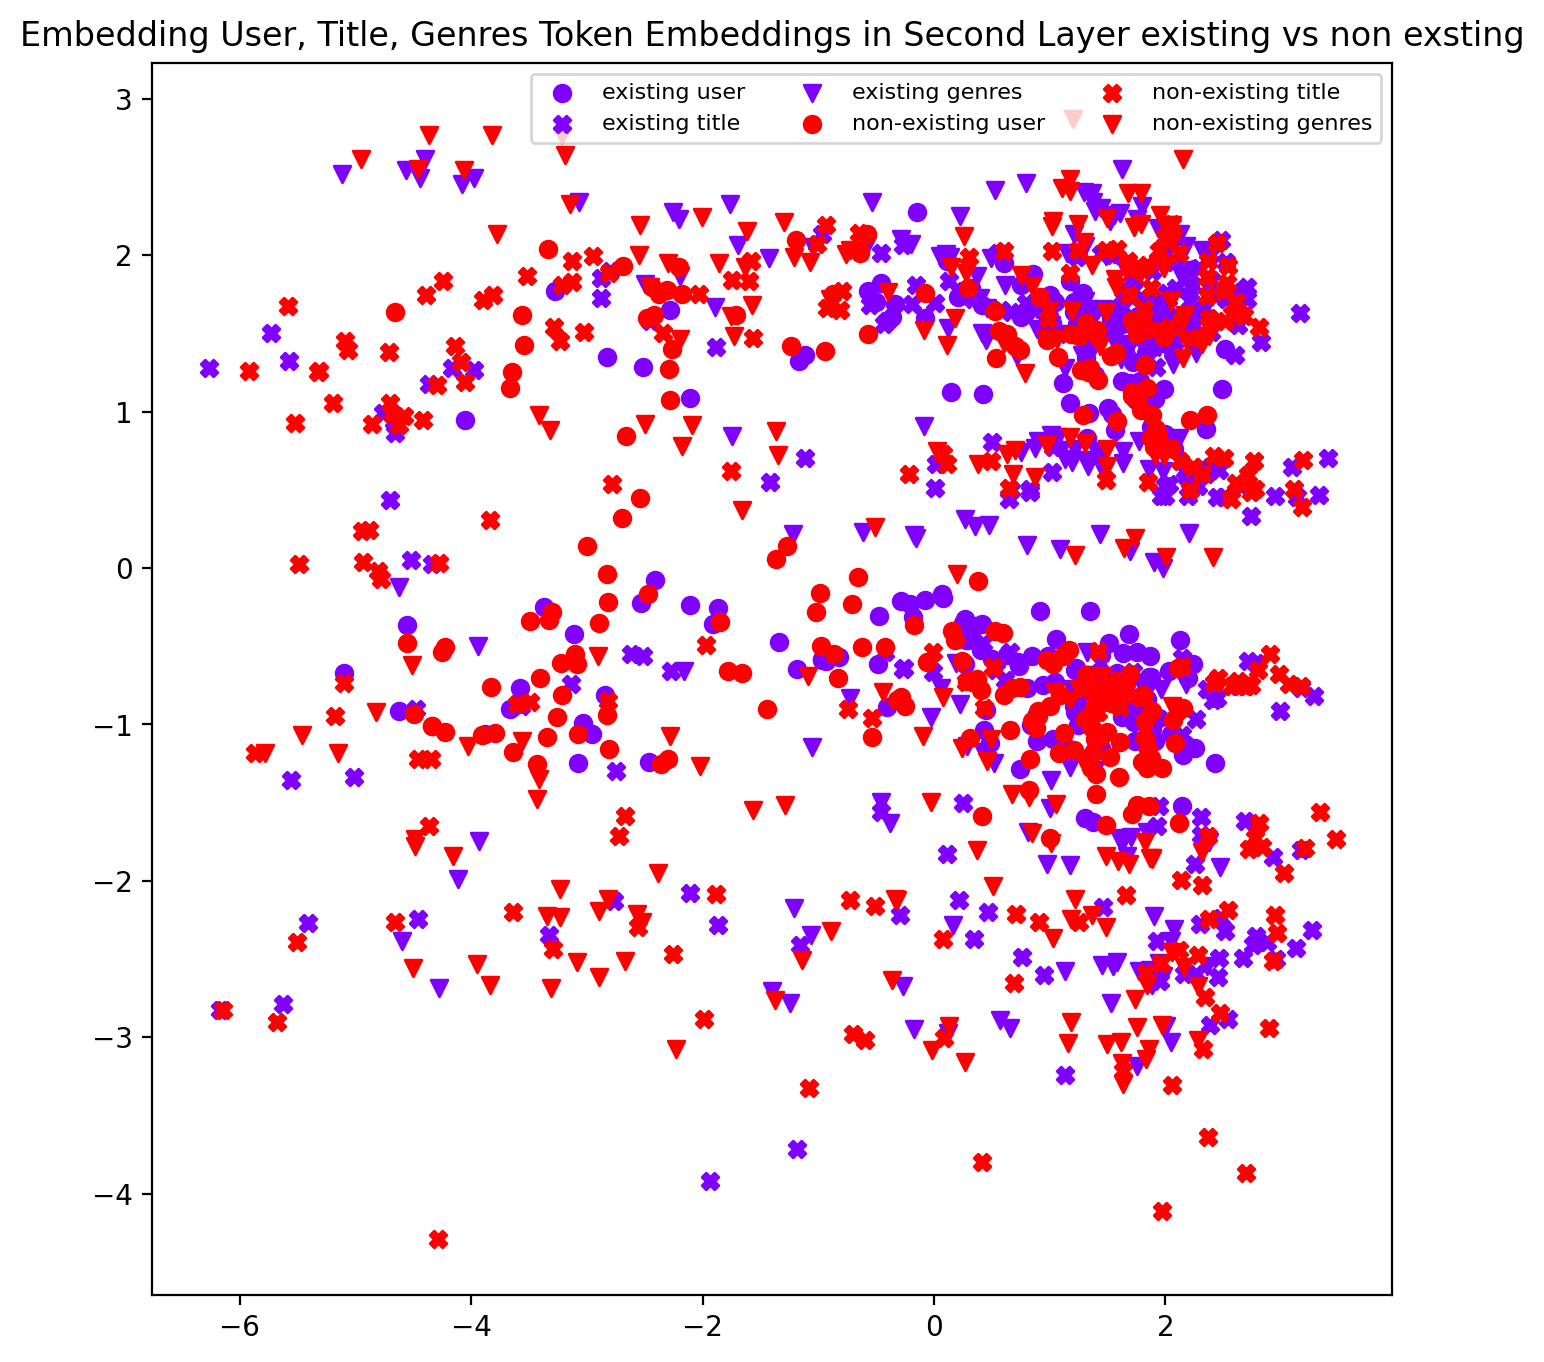

<Figure size 1600x1600 with 0 Axes>

In [297]:
hidden_state_plotter.plot_user_movie_embeddings_in_second_layer_true_vs_non_true(samples = 200, split = "val", fig_size=(8,8))